# FMLIKH Model: Creep Response

## Learning Objectives

1. Fit FMLIKH to **creep (step stress)** experimental data
2. Analyze **multi-mode delayed yielding** with distributed time scales
3. Compare FMLIKH vs single-mode FIKH creep predictions

## Prerequisites

- NB07: FMLIKH Flow Curve
- NB04: FIKH Creep (single-mode concepts)

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os, sys, time, warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_ml_ikh_creep, save_fikh_results, print_convergence_summary,
    compute_fit_quality, get_fmlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Load Data

In [3]:
STRESS_PAIR = 0
time_data, gamma_dot_data, sigma_init, sigma_final = load_ml_ikh_creep(stress_pair_index=STRESS_PAIR)

strain_data = np.cumsum(gamma_dot_data[:-1] * np.diff(time_data))
strain_data = np.insert(strain_data, 0, 0.0)

print(f"Stress: {sigma_final} Pa")
print(f"Data points: {len(time_data)}")

Stress: 5.0 Pa
Data points: 70


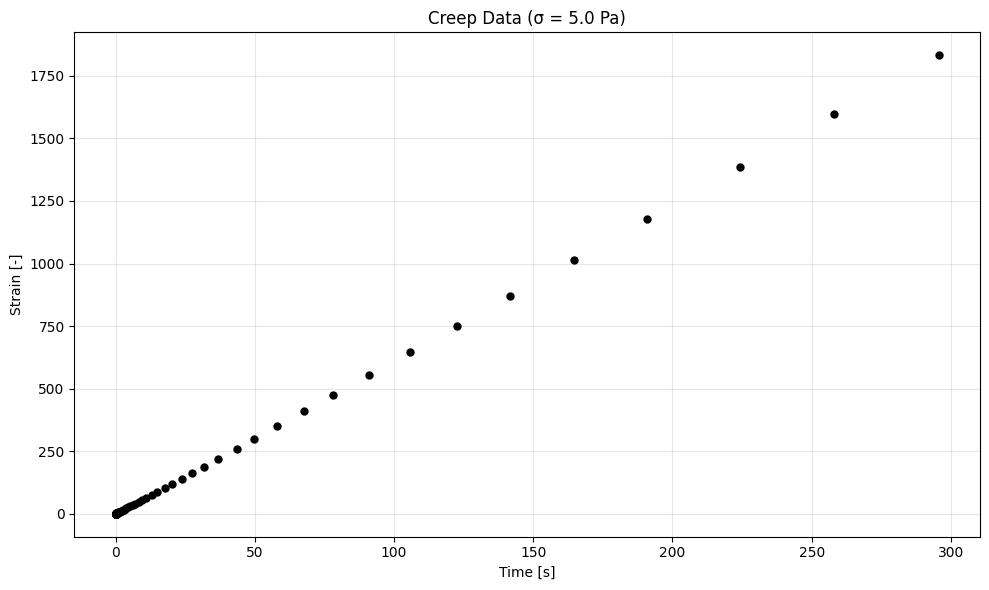

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, strain_data, "ko", markersize=5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Strain [-]")
ax.set_title(f"Creep Data (σ = {sigma_final} Pa)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 3. NLSQ Fitting

In [5]:
N_MODES = 3
model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

# For creep: we fit to strain vs time, but model needs stress history
# Create constant stress array
stress_data = np.full_like(time_data, sigma_final)

t0 = time.time()
model.fit(time_data, stress_data, test_mode="startup", strain=strain_data, method='scipy')
print(f"NLSQ time: {time.time() - t0:.2f} s")

stress_pred = model.predict(time_data, test_mode="startup", strain=strain_data)
metrics = compute_fit_quality(stress_data, stress_pred)
print(f"R² = {metrics['R2']:.6f}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 383, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ time: 0.33 s
R² = 0.000000


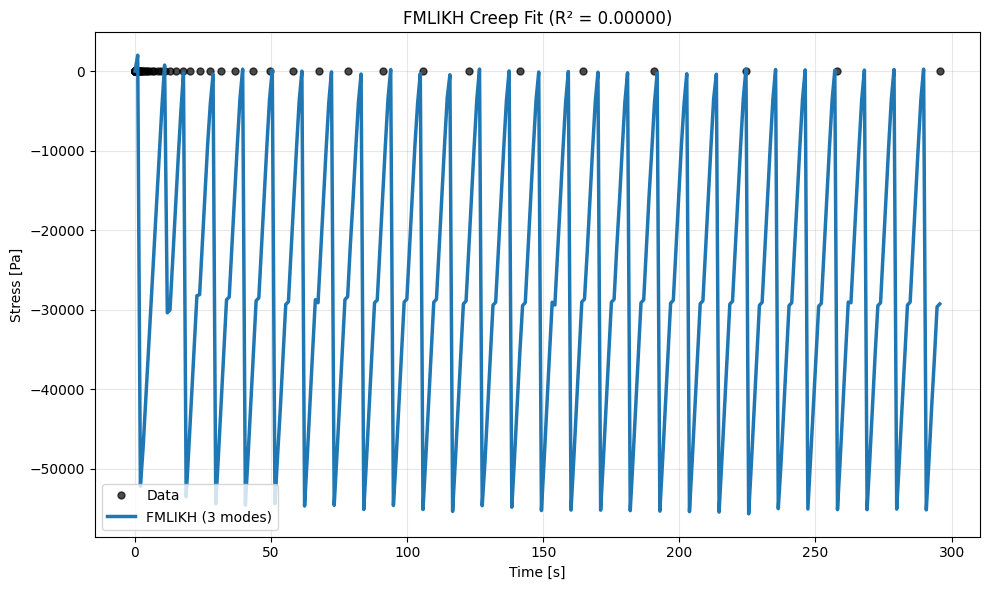

In [6]:
time_fine = np.linspace(time_data.min(), time_data.max(), 300)
# Interpolate strain for fine time points
strain_fine = np.interp(time_fine, time_data, strain_data)
stress_pred_fine = model.predict(time_fine, test_mode="startup", strain=strain_fine)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, stress_data, "ko", markersize=5, alpha=0.7, label="Data")
ax.plot(time_fine, stress_pred_fine, "-", lw=2.5, color="C0", label=f"FMLIKH ({N_MODES} modes)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title(f"FMLIKH Creep Fit (R² = {metrics['R2']:.5f})")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Bayesian Inference

In [7]:
param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model.parameters.get_value(n) for n in param_names if n in model.parameters}

NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

t0 = time.time()
result = model.fit_bayesian(
    time_data, stress_data, test_mode="startup", strain=strain_data,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
print(f"Bayesian time: {time.time() - t0:.1f} s")

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<09:46,  1.19it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   6%|▌         | 40/700 [00:00<00:11, 57.21it/s, 23 steps of size 2.32e-17. acc. prob=0.59]

warmup:   9%|▉         | 62/700 [00:19<04:09,  2.56it/s, 1023 steps of size 4.10e-19. acc. prob=0.66]

warmup:   9%|▉         | 63/700 [00:20<04:18,  2.47it/s, 1023 steps of size 3.92e-19. acc. prob=0.66]

warmup:  11%|█         | 75/700 [00:31<05:51,  1.78it/s, 1023 steps of size 2.49e-19. acc. prob=0.69]

warmup:  11%|█         | 76/700 [00:32<05:58,  1.74it/s, 1023 steps of size 3.12e-19. acc. prob=0.70]

warmup:  12%|█▏        | 84/700 [00:39<06:51,  1.50it/s, 1023 steps of size 4.93e-19. acc. prob=0.72]

warmup:  13%|█▎        | 89/700 [00:43<07:16,  1.40it/s, 1023 steps of size 3.57e-19. acc. prob=0.73]

warmup:  13%|█▎        | 93/700 [00:47<07:34,  1.34it/s, 1023 steps of size 4.72e-19. acc. prob=0.73]

warmup:  14%|█▎        | 96/700 [00:50<07:47,  1.29it/s, 1023 steps of size 5.84e-19. acc. prob=0.74]

warmup:  14%|█▍        | 98/700 [00:51<07:55,  1.27it/s, 1023 steps of size 7.74e-19. acc. prob=0.75]

warmup:  14%|█▍        | 100/700 [00:53<08:04,  1.24it/s, 1023 steps of size 7.14e-19. acc. prob=0.75]

warmup:  14%|█▍        | 101/700 [00:54<08:09,  1.22it/s, 1023 steps of size 7.27e-18. acc. prob=0.75]

warmup:  15%|█▍        | 102/700 [00:55<08:14,  1.21it/s, 1023 steps of size 7.48e-18. acc. prob=0.75]

warmup:  15%|█▍        | 103/700 [00:56<08:19,  1.19it/s, 1023 steps of size 6.85e-18. acc. prob=0.75]

warmup:  15%|█▍        | 104/700 [00:57<08:24,  1.18it/s, 1023 steps of size 7.02e-18. acc. prob=0.76]

warmup:  15%|█▌        | 105/700 [00:58<08:29,  1.17it/s, 1023 steps of size 7.23e-18. acc. prob=0.76]

warmup:  15%|█▌        | 106/700 [00:59<08:33,  1.16it/s, 1023 steps of size 6.95e-18. acc. prob=0.76]

warmup:  15%|█▌        | 107/700 [01:00<08:38,  1.14it/s, 1023 steps of size 6.56e-18. acc. prob=0.76]

warmup:  15%|█▌        | 108/700 [01:00<08:39,  1.14it/s, 1023 steps of size 6.76e-18. acc. prob=0.77]

warmup:  16%|█▌        | 109/700 [01:01<08:40,  1.14it/s, 1023 steps of size 5.79e-18. acc. prob=0.77]

warmup:  16%|█▌        | 110/700 [01:02<08:41,  1.13it/s, 1023 steps of size 5.97e-18. acc. prob=0.77]

warmup:  16%|█▌        | 111/700 [01:03<08:41,  1.13it/s, 1023 steps of size 6.17e-18. acc. prob=0.77]

warmup:  16%|█▌        | 112/700 [01:04<08:41,  1.13it/s, 1023 steps of size 6.14e-18. acc. prob=0.77]

warmup:  16%|█▌        | 113/700 [01:05<08:41,  1.13it/s, 1023 steps of size 6.34e-18. acc. prob=0.78]

warmup:  16%|█▋        | 114/700 [01:06<08:41,  1.12it/s, 1023 steps of size 5.55e-18. acc. prob=0.78]

warmup:  16%|█▋        | 115/700 [01:07<08:40,  1.12it/s, 1023 steps of size 5.68e-18. acc. prob=0.78]

warmup:  17%|█▋        | 116/700 [01:08<08:38,  1.13it/s, 1023 steps of size 5.60e-18. acc. prob=0.78]

warmup:  17%|█▋        | 117/700 [01:08<08:37,  1.13it/s, 1023 steps of size 4.52e-18. acc. prob=0.78]

warmup:  17%|█▋        | 118/700 [01:09<08:36,  1.13it/s, 1023 steps of size 4.58e-18. acc. prob=0.78]

warmup:  17%|█▋        | 119/700 [01:10<08:36,  1.12it/s, 1023 steps of size 4.74e-18. acc. prob=0.79]

warmup:  17%|█▋        | 120/700 [01:11<08:35,  1.12it/s, 1023 steps of size 4.74e-18. acc. prob=0.79]

warmup:  17%|█▋        | 121/700 [01:12<08:34,  1.12it/s, 1023 steps of size 4.87e-18. acc. prob=0.79]

warmup:  17%|█▋        | 122/700 [01:13<08:35,  1.12it/s, 1023 steps of size 5.01e-18. acc. prob=0.79]

warmup:  18%|█▊        | 123/700 [01:14<08:34,  1.12it/s, 1023 steps of size 5.17e-18. acc. prob=0.79]

warmup:  18%|█▊        | 124/700 [01:15<08:34,  1.12it/s, 1023 steps of size 5.11e-18. acc. prob=0.79]

warmup:  18%|█▊        | 125/700 [01:16<08:33,  1.12it/s, 1023 steps of size 3.87e-18. acc. prob=0.79]

warmup:  18%|█▊        | 126/700 [01:16<08:31,  1.12it/s, 1023 steps of size 4.01e-18. acc. prob=0.80]

warmup:  18%|█▊        | 127/700 [01:17<08:29,  1.12it/s, 1023 steps of size 4.14e-18. acc. prob=0.80]

warmup:  18%|█▊        | 128/700 [01:18<08:28,  1.12it/s, 1023 steps of size 4.13e-18. acc. prob=0.80]

warmup:  18%|█▊        | 129/700 [01:19<08:27,  1.12it/s, 1023 steps of size 4.26e-18. acc. prob=0.80]

warmup:  19%|█▊        | 130/700 [01:20<08:26,  1.12it/s, 1023 steps of size 4.16e-18. acc. prob=0.80]

warmup:  19%|█▊        | 131/700 [01:21<08:26,  1.12it/s, 1023 steps of size 3.96e-18. acc. prob=0.80]

warmup:  19%|█▉        | 132/700 [01:22<08:26,  1.12it/s, 1023 steps of size 4.09e-18. acc. prob=0.80]

warmup:  19%|█▉        | 133/700 [01:23<08:25,  1.12it/s, 1023 steps of size 4.13e-18. acc. prob=0.81]

warmup:  19%|█▉        | 134/700 [01:24<08:23,  1.12it/s, 1023 steps of size 4.26e-18. acc. prob=0.81]

warmup:  19%|█▉        | 135/700 [01:24<08:23,  1.12it/s, 1023 steps of size 4.37e-18. acc. prob=0.81]

warmup:  19%|█▉        | 136/700 [01:25<08:21,  1.12it/s, 1023 steps of size 4.25e-18. acc. prob=0.81]

warmup:  20%|█▉        | 137/700 [01:26<08:20,  1.12it/s, 1023 steps of size 4.28e-18. acc. prob=0.81]

warmup:  20%|█▉        | 138/700 [01:27<08:19,  1.12it/s, 1023 steps of size 4.41e-18. acc. prob=0.81]

warmup:  20%|█▉        | 139/700 [01:28<08:18,  1.12it/s, 1023 steps of size 4.47e-18. acc. prob=0.81]

warmup:  20%|██        | 140/700 [01:29<08:20,  1.12it/s, 1023 steps of size 4.39e-18. acc. prob=0.82]

warmup:  20%|██        | 141/700 [01:30<08:19,  1.12it/s, 1023 steps of size 4.35e-18. acc. prob=0.82]

warmup:  20%|██        | 142/700 [01:31<08:18,  1.12it/s, 1023 steps of size 4.47e-18. acc. prob=0.82]

warmup:  20%|██        | 143/700 [01:32<08:16,  1.12it/s, 1023 steps of size 4.60e-18. acc. prob=0.82]

warmup:  21%|██        | 144/700 [01:32<08:15,  1.12it/s, 1023 steps of size 4.71e-18. acc. prob=0.82]

warmup:  21%|██        | 145/700 [01:33<08:15,  1.12it/s, 1023 steps of size 4.84e-18. acc. prob=0.82]

warmup:  21%|██        | 146/700 [01:34<08:14,  1.12it/s, 1023 steps of size 4.84e-18. acc. prob=0.82]

warmup:  21%|██        | 147/700 [01:35<08:13,  1.12it/s, 1023 steps of size 4.55e-18. acc. prob=0.82]

warmup:  21%|██        | 148/700 [01:36<08:12,  1.12it/s, 1023 steps of size 4.39e-18. acc. prob=0.82]

warmup:  21%|██▏       | 149/700 [01:37<08:12,  1.12it/s, 1023 steps of size 4.42e-18. acc. prob=0.83]

warmup:  21%|██▏       | 150/700 [01:38<08:10,  1.12it/s, 1023 steps of size 4.34e-18. acc. prob=0.83]

warmup:  22%|██▏       | 151/700 [01:39<08:09,  1.12it/s, 1023 steps of size 4.42e-17. acc. prob=0.83]

warmup:  22%|██▏       | 152/700 [01:40<08:08,  1.12it/s, 1023 steps of size 3.22e-17. acc. prob=0.83]

warmup:  22%|██▏       | 153/700 [01:41<08:07,  1.12it/s, 1023 steps of size 2.83e-17. acc. prob=0.83]

warmup:  22%|██▏       | 154/700 [01:41<08:05,  1.12it/s, 1023 steps of size 2.73e-17. acc. prob=0.83]

warmup:  22%|██▏       | 155/700 [01:42<08:04,  1.12it/s, 1023 steps of size 2.50e-17. acc. prob=0.83]

warmup:  22%|██▏       | 156/700 [01:43<08:04,  1.12it/s, 1023 steps of size 2.12e-17. acc. prob=0.83]

warmup:  22%|██▏       | 157/700 [01:44<08:03,  1.12it/s, 1023 steps of size 1.85e-17. acc. prob=0.83]

warmup:  23%|██▎       | 158/700 [01:45<08:02,  1.12it/s, 1023 steps of size 1.63e-17. acc. prob=0.83]

warmup:  23%|██▎       | 159/700 [01:46<08:04,  1.12it/s, 1023 steps of size 1.52e-17. acc. prob=0.83]

warmup:  23%|██▎       | 160/700 [01:47<08:03,  1.12it/s, 1023 steps of size 1.55e-17. acc. prob=0.84]

warmup:  23%|██▎       | 161/700 [01:48<08:00,  1.12it/s, 1023 steps of size 1.36e-17. acc. prob=0.84]

warmup:  23%|██▎       | 162/700 [01:49<07:59,  1.12it/s, 1023 steps of size 1.29e-17. acc. prob=0.84]

warmup:  23%|██▎       | 163/700 [01:49<08:05,  1.11it/s, 1023 steps of size 1.25e-17. acc. prob=0.84]

warmup:  23%|██▎       | 164/700 [01:50<08:02,  1.11it/s, 1023 steps of size 1.30e-17. acc. prob=0.84]

warmup:  24%|██▎       | 165/700 [01:51<07:59,  1.11it/s, 1023 steps of size 9.60e-18. acc. prob=0.84]

warmup:  24%|██▎       | 166/700 [01:52<07:59,  1.11it/s, 1023 steps of size 9.87e-18. acc. prob=0.84]

warmup:  24%|██▍       | 167/700 [01:53<07:57,  1.12it/s, 1023 steps of size 9.00e-18. acc. prob=0.84]

warmup:  24%|██▍       | 168/700 [01:54<07:56,  1.12it/s, 1023 steps of size 7.69e-18. acc. prob=0.84]

warmup:  24%|██▍       | 169/700 [01:55<07:55,  1.12it/s, 1023 steps of size 7.93e-18. acc. prob=0.84]

warmup:  24%|██▍       | 170/700 [01:56<07:54,  1.12it/s, 1023 steps of size 6.47e-18. acc. prob=0.84]

warmup:  24%|██▍       | 171/700 [01:57<07:54,  1.12it/s, 1023 steps of size 5.92e-18. acc. prob=0.84]

warmup:  25%|██▍       | 172/700 [01:58<07:52,  1.12it/s, 1023 steps of size 5.92e-18. acc. prob=0.84]

warmup:  25%|██▍       | 173/700 [01:58<07:50,  1.12it/s, 1023 steps of size 5.21e-18. acc. prob=0.84]

warmup:  25%|██▍       | 174/700 [01:59<07:49,  1.12it/s, 1023 steps of size 5.02e-18. acc. prob=0.85]

warmup:  25%|██▌       | 175/700 [02:00<07:48,  1.12it/s, 1023 steps of size 5.24e-18. acc. prob=0.85]

warmup:  25%|██▌       | 176/700 [02:01<07:47,  1.12it/s, 1023 steps of size 5.32e-18. acc. prob=0.85]

warmup:  25%|██▌       | 177/700 [02:02<07:46,  1.12it/s, 1023 steps of size 5.43e-18. acc. prob=0.85]

warmup:  25%|██▌       | 178/700 [02:03<07:45,  1.12it/s, 1023 steps of size 5.44e-18. acc. prob=0.85]

warmup:  26%|██▌       | 179/700 [02:04<07:45,  1.12it/s, 1023 steps of size 5.61e-18. acc. prob=0.85]

warmup:  26%|██▌       | 180/700 [02:05<07:44,  1.12it/s, 1023 steps of size 3.96e-18. acc. prob=0.85]

warmup:  26%|██▌       | 181/700 [02:06<07:42,  1.12it/s, 1023 steps of size 4.15e-18. acc. prob=0.85]

warmup:  26%|██▌       | 182/700 [02:06<07:41,  1.12it/s, 1023 steps of size 4.21e-18. acc. prob=0.85]

warmup:  26%|██▌       | 183/700 [02:07<07:40,  1.12it/s, 1023 steps of size 4.41e-18. acc. prob=0.85]

warmup:  26%|██▋       | 184/700 [02:08<07:39,  1.12it/s, 1023 steps of size 4.61e-18. acc. prob=0.85]

warmup:  26%|██▋       | 185/700 [02:09<07:38,  1.12it/s, 1023 steps of size 4.82e-18. acc. prob=0.85]

warmup:  27%|██▋       | 186/700 [02:10<07:38,  1.12it/s, 1023 steps of size 5.03e-18. acc. prob=0.85]

warmup:  27%|██▋       | 187/700 [02:11<07:37,  1.12it/s, 1023 steps of size 4.91e-18. acc. prob=0.85]

warmup:  27%|██▋       | 188/700 [02:12<07:35,  1.12it/s, 1023 steps of size 4.34e-18. acc. prob=0.86]

warmup:  27%|██▋       | 189/700 [02:13<07:35,  1.12it/s, 1023 steps of size 4.53e-18. acc. prob=0.86]

warmup:  27%|██▋       | 190/700 [02:14<07:33,  1.12it/s, 1023 steps of size 4.48e-18. acc. prob=0.86]

warmup:  27%|██▋       | 191/700 [02:14<07:34,  1.12it/s, 1023 steps of size 4.50e-18. acc. prob=0.86]

warmup:  27%|██▋       | 192/700 [02:15<07:34,  1.12it/s, 1023 steps of size 4.56e-18. acc. prob=0.86]

warmup:  28%|██▊       | 193/700 [02:16<07:33,  1.12it/s, 1023 steps of size 4.76e-18. acc. prob=0.86]

warmup:  28%|██▊       | 194/700 [02:17<07:31,  1.12it/s, 1023 steps of size 4.95e-18. acc. prob=0.86]

warmup:  28%|██▊       | 195/700 [02:18<07:30,  1.12it/s, 1023 steps of size 5.15e-18. acc. prob=0.86]

warmup:  28%|██▊       | 196/700 [02:19<07:29,  1.12it/s, 1023 steps of size 5.12e-18. acc. prob=0.86]

warmup:  28%|██▊       | 197/700 [02:20<07:28,  1.12it/s, 1023 steps of size 5.32e-18. acc. prob=0.86]

warmup:  28%|██▊       | 198/700 [02:21<07:27,  1.12it/s, 1023 steps of size 5.53e-18. acc. prob=0.86]

warmup:  28%|██▊       | 199/700 [02:22<07:27,  1.12it/s, 1023 steps of size 5.22e-18. acc. prob=0.86]

warmup:  29%|██▊       | 200/700 [02:22<07:25,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.86]

sample:  29%|██▊       | 201/700 [02:23<07:24,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  29%|██▉       | 202/700 [02:24<07:23,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.95]

sample:  29%|██▉       | 203/700 [02:25<07:22,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.97]

sample:  29%|██▉       | 204/700 [02:26<07:22,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.97]

sample:  29%|██▉       | 205/700 [02:27<07:21,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  29%|██▉       | 206/700 [02:28<07:21,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  30%|██▉       | 207/700 [02:29<07:20,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  30%|██▉       | 208/700 [02:30<07:18,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  30%|██▉       | 209/700 [02:31<07:17,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  30%|███       | 210/700 [02:31<07:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  30%|███       | 211/700 [02:32<07:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  30%|███       | 212/700 [02:33<07:14,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  30%|███       | 213/700 [02:34<07:14,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  31%|███       | 214/700 [02:35<07:13,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  31%|███       | 215/700 [02:36<07:13,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  31%|███       | 216/700 [02:37<07:12,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  31%|███       | 217/700 [02:38<07:11,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  31%|███       | 218/700 [02:39<07:09,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  31%|███▏      | 219/700 [02:39<07:08,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [02:40<07:08,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [02:41<07:07,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [02:42<07:07,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  32%|███▏      | 223/700 [02:43<07:06,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [02:44<07:04,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [02:45<07:03,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [02:46<07:02,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  32%|███▏      | 227/700 [02:47<07:01,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  33%|███▎      | 228/700 [02:47<07:00,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [02:48<06:59,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  33%|███▎      | 230/700 [02:49<06:58,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  33%|███▎      | 231/700 [02:50<06:58,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  33%|███▎      | 232/700 [02:51<06:57,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  33%|███▎      | 233/700 [02:52<06:57,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  33%|███▎      | 234/700 [02:53<06:55,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  34%|███▎      | 235/700 [02:54<06:54,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  34%|███▎      | 236/700 [02:55<06:54,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  34%|███▍      | 237/700 [02:56<06:53,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  34%|███▍      | 238/700 [02:56<06:53,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [02:57<06:52,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  34%|███▍      | 240/700 [02:58<06:50,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [02:59<06:49,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  35%|███▍      | 242/700 [03:00<06:48,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [03:01<06:47,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  35%|███▍      | 244/700 [03:02<06:46,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [03:03<06:45,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  35%|███▌      | 246/700 [03:04<06:44,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  35%|███▌      | 247/700 [03:04<06:49,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  35%|███▌      | 248/700 [03:05<06:46,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  36%|███▌      | 249/700 [03:06<06:44,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  36%|███▌      | 250/700 [03:07<06:44,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  36%|███▌      | 251/700 [03:08<06:44,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  36%|███▌      | 252/700 [03:09<06:42,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  36%|███▌      | 253/700 [03:10<06:42,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  36%|███▋      | 254/700 [03:11<06:40,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [03:12<06:38,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  37%|███▋      | 256/700 [03:13<06:36,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  37%|███▋      | 257/700 [03:13<06:35,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  37%|███▋      | 258/700 [03:14<06:34,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  37%|███▋      | 259/700 [03:15<06:33,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  37%|███▋      | 260/700 [03:16<06:33,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  37%|███▋      | 261/700 [03:17<06:34,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  37%|███▋      | 262/700 [03:18<06:32,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  38%|███▊      | 263/700 [03:19<06:31,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  38%|███▊      | 264/700 [03:20<06:29,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [03:21<06:28,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  38%|███▊      | 266/700 [03:21<06:27,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  38%|███▊      | 267/700 [03:22<06:26,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  38%|███▊      | 268/700 [03:23<06:25,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  38%|███▊      | 269/700 [03:24<06:24,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  39%|███▊      | 270/700 [03:25<06:23,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  39%|███▊      | 271/700 [03:26<06:22,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  39%|███▉      | 272/700 [03:27<06:22,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [03:28<06:21,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  39%|███▉      | 274/700 [03:29<06:19,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  39%|███▉      | 275/700 [03:29<06:18,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  39%|███▉      | 276/700 [03:30<06:18,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  40%|███▉      | 277/700 [03:31<06:17,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  40%|███▉      | 278/700 [03:32<06:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  40%|███▉      | 279/700 [03:33<06:15,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  40%|████      | 280/700 [03:34<06:14,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  40%|████      | 281/700 [03:35<06:13,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  40%|████      | 282/700 [03:36<06:12,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  40%|████      | 283/700 [03:37<06:11,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  41%|████      | 284/700 [03:38<06:11,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  41%|████      | 285/700 [03:38<06:10,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  41%|████      | 286/700 [03:39<06:09,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  41%|████      | 287/700 [03:40<06:08,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  41%|████      | 288/700 [03:41<06:08,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  41%|████▏     | 289/700 [03:42<06:07,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  41%|████▏     | 290/700 [03:43<06:06,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  42%|████▏     | 291/700 [03:44<06:04,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  42%|████▏     | 292/700 [03:45<06:03,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  42%|████▏     | 293/700 [03:46<06:02,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  42%|████▏     | 294/700 [03:46<06:01,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  42%|████▏     | 295/700 [03:47<06:01,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  42%|████▏     | 296/700 [03:48<06:00,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  42%|████▏     | 297/700 [03:49<05:59,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  43%|████▎     | 298/700 [03:50<05:58,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  43%|████▎     | 299/700 [03:51<05:57,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  43%|████▎     | 300/700 [03:52<05:57,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  43%|████▎     | 301/700 [03:53<05:56,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  43%|████▎     | 302/700 [03:54<05:55,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  43%|████▎     | 303/700 [03:54<05:53,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  43%|████▎     | 304/700 [03:55<05:53,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  44%|████▎     | 305/700 [03:56<05:51,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  44%|████▎     | 306/700 [03:57<05:51,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  44%|████▍     | 307/700 [03:58<05:51,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  44%|████▍     | 308/700 [03:59<05:50,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  44%|████▍     | 309/700 [04:00<05:49,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  44%|████▍     | 310/700 [04:01<05:47,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  44%|████▍     | 311/700 [04:02<05:47,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  45%|████▍     | 312/700 [04:03<05:46,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  45%|████▍     | 313/700 [04:03<05:45,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.98]

sample:  45%|████▍     | 314/700 [04:04<05:44,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  45%|████▌     | 315/700 [04:05<05:43,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  45%|████▌     | 316/700 [04:06<05:42,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  45%|████▌     | 317/700 [04:07<05:43,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [04:08<05:42,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  46%|████▌     | 319/700 [04:09<05:40,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  46%|████▌     | 320/700 [04:10<05:39,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  46%|████▌     | 321/700 [04:11<05:38,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  46%|████▌     | 322/700 [04:11<05:37,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  46%|████▌     | 323/700 [04:12<05:36,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  46%|████▋     | 324/700 [04:13<05:35,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  46%|████▋     | 325/700 [04:14<05:34,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  47%|████▋     | 326/700 [04:15<05:33,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [04:16<05:32,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  47%|████▋     | 328/700 [04:17<05:31,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [04:18<05:30,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  47%|████▋     | 330/700 [04:19<05:30,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  47%|████▋     | 331/700 [04:19<05:29,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  47%|████▋     | 332/700 [04:20<05:28,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  48%|████▊     | 333/700 [04:21<05:27,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  48%|████▊     | 334/700 [04:22<05:26,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  48%|████▊     | 335/700 [04:23<05:25,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  48%|████▊     | 336/700 [04:24<05:24,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  48%|████▊     | 337/700 [04:25<05:23,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  48%|████▊     | 338/700 [04:26<05:22,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  48%|████▊     | 339/700 [04:27<05:21,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  49%|████▊     | 340/700 [04:27<05:20,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  49%|████▊     | 341/700 [04:28<05:19,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [04:29<05:18,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  49%|████▉     | 343/700 [04:30<05:17,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  49%|████▉     | 344/700 [04:31<05:17,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  49%|████▉     | 345/700 [04:32<05:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  49%|████▉     | 346/700 [04:33<05:15,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  50%|████▉     | 347/700 [04:34<05:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  50%|████▉     | 348/700 [04:35<05:14,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  50%|████▉     | 349/700 [04:36<05:13,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  50%|█████     | 350/700 [04:36<05:12,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  50%|█████     | 351/700 [04:37<05:11,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  50%|█████     | 352/700 [04:38<05:09,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  50%|█████     | 353/700 [04:39<05:10,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  51%|█████     | 354/700 [04:40<05:09,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  51%|█████     | 355/700 [04:41<05:08,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  51%|█████     | 356/700 [04:42<05:06,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  51%|█████     | 357/700 [04:43<05:05,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  51%|█████     | 358/700 [04:44<05:04,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  51%|█████▏    | 359/700 [04:44<05:04,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  51%|█████▏    | 360/700 [04:45<05:03,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  52%|█████▏    | 361/700 [04:46<05:02,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  52%|█████▏    | 362/700 [04:47<05:01,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  52%|█████▏    | 363/700 [04:48<05:00,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  52%|█████▏    | 364/700 [04:49<04:58,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  52%|█████▏    | 365/700 [04:50<04:57,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  52%|█████▏    | 366/700 [04:51<04:57,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  52%|█████▏    | 367/700 [04:52<04:56,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  53%|█████▎    | 368/700 [04:52<04:56,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  53%|█████▎    | 369/700 [04:53<04:55,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [04:54<04:54,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  53%|█████▎    | 371/700 [04:55<04:53,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  53%|█████▎    | 372/700 [04:56<04:52,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  53%|█████▎    | 373/700 [04:57<04:51,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  53%|█████▎    | 374/700 [04:58<04:50,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  54%|█████▎    | 375/700 [04:59<04:49,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  54%|█████▎    | 376/700 [05:00<04:49,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  54%|█████▍    | 377/700 [05:00<04:49,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  54%|█████▍    | 378/700 [05:01<04:47,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  54%|█████▍    | 379/700 [05:02<04:47,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  54%|█████▍    | 380/700 [05:03<04:46,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  54%|█████▍    | 381/700 [05:04<04:45,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  55%|█████▍    | 382/700 [05:05<04:44,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  55%|█████▍    | 383/700 [05:06<04:42,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  55%|█████▍    | 384/700 [05:07<04:41,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [05:08<04:40,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  55%|█████▌    | 386/700 [05:09<04:39,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  55%|█████▌    | 387/700 [05:09<04:38,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  55%|█████▌    | 388/700 [05:10<04:37,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  56%|█████▌    | 389/700 [05:11<04:37,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [05:12<04:36,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  56%|█████▌    | 391/700 [05:13<04:35,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  56%|█████▌    | 392/700 [05:14<04:34,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  56%|█████▌    | 393/700 [05:15<04:34,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  56%|█████▋    | 394/700 [05:16<04:33,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  56%|█████▋    | 395/700 [05:17<04:32,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  57%|█████▋    | 396/700 [05:17<04:31,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  57%|█████▋    | 397/700 [05:18<04:30,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  57%|█████▋    | 398/700 [05:19<04:30,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  57%|█████▋    | 399/700 [05:20<04:29,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  57%|█████▋    | 400/700 [05:21<04:29,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [05:22<04:27,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  57%|█████▋    | 402/700 [05:23<04:26,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  58%|█████▊    | 403/700 [05:24<04:25,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  58%|█████▊    | 404/700 [05:25<04:24,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  58%|█████▊    | 405/700 [05:25<04:23,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  58%|█████▊    | 406/700 [05:26<04:22,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  58%|█████▊    | 407/700 [05:27<04:21,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  58%|█████▊    | 408/700 [05:28<04:20,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  58%|█████▊    | 409/700 [05:29<04:19,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  59%|█████▊    | 410/700 [05:30<04:18,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  59%|█████▊    | 411/700 [05:31<04:17,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  59%|█████▉    | 412/700 [05:32<04:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [05:33<04:15,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  59%|█████▉    | 414/700 [05:34<04:14,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  59%|█████▉    | 415/700 [05:34<04:13,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  59%|█████▉    | 416/700 [05:35<04:12,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  60%|█████▉    | 417/700 [05:36<04:11,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  60%|█████▉    | 418/700 [05:37<04:10,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  60%|█████▉    | 419/700 [05:38<04:09,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  60%|██████    | 420/700 [05:39<04:10,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  60%|██████    | 421/700 [05:40<04:09,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  60%|██████    | 422/700 [05:41<04:08,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  60%|██████    | 423/700 [05:42<04:07,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  61%|██████    | 424/700 [05:42<04:06,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  61%|██████    | 425/700 [05:43<04:05,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  61%|██████    | 426/700 [05:44<04:04,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  61%|██████    | 427/700 [05:45<04:03,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  61%|██████    | 428/700 [05:46<04:02,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  61%|██████▏   | 429/700 [05:47<04:01,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  61%|██████▏   | 430/700 [05:48<04:00,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  62%|██████▏   | 431/700 [05:49<03:59,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  62%|██████▏   | 432/700 [05:50<03:58,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  62%|██████▏   | 433/700 [05:50<03:57,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  62%|██████▏   | 434/700 [05:51<03:56,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  62%|██████▏   | 435/700 [05:52<03:56,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  62%|██████▏   | 436/700 [05:53<03:55,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  62%|██████▏   | 437/700 [05:54<03:54,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  63%|██████▎   | 438/700 [05:55<03:54,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  63%|██████▎   | 439/700 [05:56<03:53,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  63%|██████▎   | 440/700 [05:57<03:52,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  63%|██████▎   | 441/700 [05:58<03:51,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  63%|██████▎   | 442/700 [05:58<03:50,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  63%|██████▎   | 443/700 [05:59<03:48,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  63%|██████▎   | 444/700 [06:00<03:47,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  64%|██████▎   | 445/700 [06:01<03:47,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  64%|██████▎   | 446/700 [06:02<03:47,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  64%|██████▍   | 447/700 [06:03<03:46,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  64%|██████▍   | 448/700 [06:04<03:44,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  64%|██████▍   | 449/700 [06:05<03:43,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  64%|██████▍   | 450/700 [06:06<03:42,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [06:06<03:41,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  65%|██████▍   | 452/700 [06:07<03:43,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  65%|██████▍   | 453/700 [06:08<03:41,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  65%|██████▍   | 454/700 [06:09<03:40,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  65%|██████▌   | 455/700 [06:10<03:39,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  65%|██████▌   | 456/700 [06:11<03:38,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  65%|██████▌   | 457/700 [06:12<03:36,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  65%|██████▌   | 458/700 [06:13<03:35,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  66%|██████▌   | 459/700 [06:14<03:34,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  66%|██████▌   | 460/700 [06:15<03:33,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  66%|██████▌   | 461/700 [06:15<03:32,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  66%|██████▌   | 462/700 [06:16<03:31,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  66%|██████▌   | 463/700 [06:17<03:30,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  66%|██████▋   | 464/700 [06:18<03:30,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  66%|██████▋   | 465/700 [06:19<03:29,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  67%|██████▋   | 466/700 [06:20<03:28,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  67%|██████▋   | 467/700 [06:21<03:27,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  67%|██████▋   | 468/700 [06:22<03:26,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  67%|██████▋   | 469/700 [06:23<03:28,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  67%|██████▋   | 470/700 [06:23<03:26,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [06:24<03:24,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  67%|██████▋   | 472/700 [06:25<03:23,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  68%|██████▊   | 473/700 [06:26<03:27,  1.09it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  68%|██████▊   | 474/700 [06:27<03:24,  1.10it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  68%|██████▊   | 475/700 [06:28<03:23,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  68%|██████▊   | 476/700 [06:29<03:21,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  68%|██████▊   | 477/700 [06:30<03:19,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  68%|██████▊   | 478/700 [06:31<03:18,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  68%|██████▊   | 479/700 [06:32<03:17,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  69%|██████▊   | 480/700 [06:32<03:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  69%|██████▊   | 481/700 [06:33<03:15,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  69%|██████▉   | 482/700 [06:34<03:14,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  69%|██████▉   | 483/700 [06:35<03:13,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  69%|██████▉   | 484/700 [06:36<03:12,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  69%|██████▉   | 485/700 [06:37<03:11,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  69%|██████▉   | 486/700 [06:38<03:10,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  70%|██████▉   | 487/700 [06:39<03:09,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  70%|██████▉   | 488/700 [06:40<03:08,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  70%|██████▉   | 489/700 [06:40<03:07,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  70%|███████   | 490/700 [06:41<03:06,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  70%|███████   | 491/700 [06:42<03:06,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  70%|███████   | 492/700 [06:43<03:05,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  70%|███████   | 493/700 [06:44<03:04,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  71%|███████   | 494/700 [06:45<03:03,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  71%|███████   | 495/700 [06:46<03:02,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  71%|███████   | 496/700 [06:47<03:01,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  71%|███████   | 497/700 [06:48<03:00,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  71%|███████   | 498/700 [06:48<02:59,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  71%|███████▏  | 499/700 [06:49<02:58,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  71%|███████▏  | 500/700 [06:50<02:57,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  72%|███████▏  | 501/700 [06:51<02:56,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [06:52<02:56,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  72%|███████▏  | 503/700 [06:53<02:55,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  72%|███████▏  | 504/700 [06:54<02:54,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  72%|███████▏  | 505/700 [06:55<02:53,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  72%|███████▏  | 506/700 [06:56<02:52,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  72%|███████▏  | 507/700 [06:56<02:51,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  73%|███████▎  | 508/700 [06:57<02:50,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  73%|███████▎  | 509/700 [06:58<02:49,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  73%|███████▎  | 510/700 [06:59<02:48,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [07:00<02:47,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  73%|███████▎  | 512/700 [07:01<02:46,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  73%|███████▎  | 513/700 [07:02<02:45,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  73%|███████▎  | 514/700 [07:03<02:45,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  74%|███████▎  | 515/700 [07:04<02:44,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  74%|███████▎  | 516/700 [07:04<02:44,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  74%|███████▍  | 517/700 [07:05<02:43,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  74%|███████▍  | 518/700 [07:06<02:41,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  74%|███████▍  | 519/700 [07:07<02:40,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  74%|███████▍  | 520/700 [07:08<02:39,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  74%|███████▍  | 521/700 [07:09<02:39,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [07:10<02:38,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  75%|███████▍  | 523/700 [07:11<02:37,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  75%|███████▍  | 524/700 [07:12<02:36,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  75%|███████▌  | 525/700 [07:12<02:35,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  75%|███████▌  | 526/700 [07:13<02:34,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  75%|███████▌  | 527/700 [07:14<02:33,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  75%|███████▌  | 528/700 [07:15<02:32,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  76%|███████▌  | 529/700 [07:16<02:31,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [07:17<02:31,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [07:18<02:30,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  76%|███████▌  | 532/700 [07:19<02:29,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  76%|███████▌  | 533/700 [07:20<02:28,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  76%|███████▋  | 534/700 [07:20<02:27,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  76%|███████▋  | 535/700 [07:21<02:26,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [07:22<02:25,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  77%|███████▋  | 537/700 [07:23<02:24,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  77%|███████▋  | 538/700 [07:24<02:24,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  77%|███████▋  | 539/700 [07:25<02:23,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  77%|███████▋  | 540/700 [07:26<02:22,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  77%|███████▋  | 541/700 [07:27<02:21,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [07:28<02:20,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  78%|███████▊  | 543/700 [07:28<02:19,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  78%|███████▊  | 544/700 [07:29<02:18,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  78%|███████▊  | 545/700 [07:30<02:17,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [07:31<02:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [07:32<02:15,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  78%|███████▊  | 548/700 [07:33<02:14,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  78%|███████▊  | 549/700 [07:34<02:14,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [07:35<02:13,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  79%|███████▊  | 551/700 [07:36<02:12,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [07:36<02:11,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  79%|███████▉  | 553/700 [07:37<02:10,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  79%|███████▉  | 554/700 [07:38<02:09,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  79%|███████▉  | 555/700 [07:39<02:08,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  79%|███████▉  | 556/700 [07:40<02:07,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  80%|███████▉  | 557/700 [07:41<02:06,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  80%|███████▉  | 558/700 [07:42<02:06,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [07:43<02:05,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  80%|████████  | 560/700 [07:44<02:04,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  80%|████████  | 561/700 [07:44<02:03,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  80%|████████  | 562/700 [07:45<02:03,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  80%|████████  | 563/700 [07:46<02:02,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  81%|████████  | 564/700 [07:47<02:00,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  81%|████████  | 565/700 [07:48<02:00,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  81%|████████  | 566/700 [07:49<01:59,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  81%|████████  | 567/700 [07:50<01:58,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  81%|████████  | 568/700 [07:51<01:57,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  81%|████████▏ | 569/700 [07:52<01:56,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  81%|████████▏ | 570/700 [07:52<01:55,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [07:53<01:54,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  82%|████████▏ | 572/700 [07:54<01:53,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  82%|████████▏ | 573/700 [07:55<01:52,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  82%|████████▏ | 574/700 [07:56<01:52,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  82%|████████▏ | 575/700 [07:57<01:51,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  82%|████████▏ | 576/700 [07:58<01:50,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  82%|████████▏ | 577/700 [07:59<01:49,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  83%|████████▎ | 578/700 [08:00<01:48,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  83%|████████▎ | 579/700 [08:00<01:47,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  83%|████████▎ | 580/700 [08:01<01:46,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  83%|████████▎ | 581/700 [08:02<01:45,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  83%|████████▎ | 582/700 [08:03<01:44,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  83%|████████▎ | 583/700 [08:04<01:43,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  83%|████████▎ | 584/700 [08:05<01:42,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  84%|████████▎ | 585/700 [08:06<01:42,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [08:07<01:41,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [08:08<01:40,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  84%|████████▍ | 588/700 [08:08<01:39,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  84%|████████▍ | 589/700 [08:09<01:38,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  84%|████████▍ | 590/700 [08:10<01:38,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [08:11<01:37,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  85%|████████▍ | 592/700 [08:12<01:36,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  85%|████████▍ | 593/700 [08:13<01:35,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  85%|████████▍ | 594/700 [08:14<01:34,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  85%|████████▌ | 595/700 [08:15<01:33,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  85%|████████▌ | 596/700 [08:16<01:32,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  85%|████████▌ | 597/700 [08:17<01:31,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [08:17<01:30,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  86%|████████▌ | 599/700 [08:18<01:29,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  86%|████████▌ | 600/700 [08:19<01:28,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  86%|████████▌ | 601/700 [08:20<01:28,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  86%|████████▌ | 602/700 [08:21<01:27,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  86%|████████▌ | 603/700 [08:22<01:26,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  86%|████████▋ | 604/700 [08:23<01:25,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  86%|████████▋ | 605/700 [08:24<01:24,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  87%|████████▋ | 606/700 [08:25<01:23,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  87%|████████▋ | 607/700 [08:25<01:22,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  87%|████████▋ | 608/700 [08:26<01:21,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [08:27<01:21,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  87%|████████▋ | 610/700 [08:28<01:20,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  87%|████████▋ | 611/700 [08:29<01:19,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  87%|████████▋ | 612/700 [08:30<01:18,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  88%|████████▊ | 613/700 [08:31<01:17,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  88%|████████▊ | 614/700 [08:32<01:16,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [08:33<01:15,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  88%|████████▊ | 616/700 [08:33<01:15,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  88%|████████▊ | 617/700 [08:34<01:13,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  88%|████████▊ | 618/700 [08:35<01:12,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  88%|████████▊ | 619/700 [08:36<01:12,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [08:37<01:11,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  89%|████████▊ | 621/700 [08:38<01:10,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  89%|████████▉ | 622/700 [08:39<01:10,  1.11it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  89%|████████▉ | 623/700 [08:40<01:08,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [08:41<01:07,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  89%|████████▉ | 625/700 [08:41<01:06,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [08:42<01:05,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  90%|████████▉ | 627/700 [08:43<01:04,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  90%|████████▉ | 628/700 [08:44<01:03,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  90%|████████▉ | 629/700 [08:45<01:03,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  90%|█████████ | 630/700 [08:46<01:02,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [08:47<01:01,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  90%|█████████ | 632/700 [08:48<01:00,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [08:49<00:59,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [08:49<00:58,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  91%|█████████ | 635/700 [08:50<00:57,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  91%|█████████ | 636/700 [08:51<00:56,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  91%|█████████ | 637/700 [08:52<00:56,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [08:53<00:55,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [08:54<00:54,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [08:55<00:53,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [08:56<00:52,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  92%|█████████▏| 642/700 [08:57<00:51,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  92%|█████████▏| 643/700 [08:57<00:50,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  92%|█████████▏| 644/700 [08:58<00:49,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  92%|█████████▏| 645/700 [08:59<00:48,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [09:00<00:47,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  92%|█████████▏| 647/700 [09:01<00:46,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [09:02<00:46,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [09:03<00:45,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  93%|█████████▎| 650/700 [09:04<00:44,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  93%|█████████▎| 651/700 [09:05<00:43,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [09:05<00:42,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [09:06<00:41,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  93%|█████████▎| 654/700 [09:07<00:40,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  94%|█████████▎| 655/700 [09:08<00:40,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  94%|█████████▎| 656/700 [09:09<00:39,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [09:10<00:38,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [09:11<00:37,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  94%|█████████▍| 659/700 [09:12<00:36,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  94%|█████████▍| 660/700 [09:13<00:35,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [09:13<00:34,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  95%|█████████▍| 662/700 [09:14<00:33,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  95%|█████████▍| 663/700 [09:15<00:32,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  95%|█████████▍| 664/700 [09:16<00:31,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [09:17<00:31,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [09:18<00:30,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [09:19<00:29,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  95%|█████████▌| 668/700 [09:20<00:28,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [09:21<00:27,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  96%|█████████▌| 670/700 [09:21<00:26,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  96%|█████████▌| 671/700 [09:22<00:25,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [09:23<00:24,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  96%|█████████▌| 673/700 [09:24<00:23,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [09:25<00:23,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [09:26<00:22,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  97%|█████████▋| 676/700 [09:27<00:21,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  97%|█████████▋| 677/700 [09:28<00:20,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  97%|█████████▋| 678/700 [09:29<00:19,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  97%|█████████▋| 679/700 [09:29<00:18,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [09:30<00:17,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  97%|█████████▋| 681/700 [09:31<00:16,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  97%|█████████▋| 682/700 [09:32<00:15,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  98%|█████████▊| 683/700 [09:33<00:15,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  98%|█████████▊| 684/700 [09:34<00:14,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [09:35<00:13,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  98%|█████████▊| 686/700 [09:36<00:12,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [09:37<00:11,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [09:37<00:10,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  98%|█████████▊| 689/700 [09:38<00:09,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  99%|█████████▊| 690/700 [09:39<00:08,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [09:40<00:07,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [09:41<00:07,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [09:42<00:06,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [09:43<00:05,  1.12it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  99%|█████████▉| 695/700 [09:44<00:04,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample:  99%|█████████▉| 696/700 [09:45<00:03,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [09:45<00:02,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample: 100%|█████████▉| 698/700 [09:46<00:01,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample: 100%|█████████▉| 699/700 [09:47<00:00,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample: 100%|██████████| 700/700 [09:48<00:00,  1.13it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

sample: 100%|██████████| 700/700 [09:48<00:00,  1.19it/s, 1023 steps of size 5.39e-18. acc. prob=0.99]

Bayesian time: 591.7 s


In [8]:
key_params = ["G_0", "alpha_structure", "sigma_y0"]
print_convergence_summary(result, key_params)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


True

## 5. Save Results

In [9]:
save_fikh_results(model, result, "fmlikh", "creep", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/fikh/../utils/../outputs/fikh/fmlikh/creep/
  nlsq_params_creep.json: 20 parameters
  posterior_creep.json: 500 draws


## Key Takeaways

1. **Multi-mode creep** shows distributed yielding time scales
2. **Each mode contributes** to overall compliance
3. **Fractional memory** modifies approach to steady flow